In [5]:
import numpy as np
import random

# Set a global random seed
SEED = 42
np.random.seed(SEED)
random.seed(SEED)


In [8]:
"""Random Dilated Shapelet Transform (RDST) Classifier.

A Random Dilated Shapelet Transform classifier pipeline that simply performs a random
shapelet dilated transform and builds (by default) a ridge classifier on the output.
"""

__maintainer__ = ["baraline"]
__all__ = ["RDSTClassifier"]

from typing import Union
from typing import Union, List, Dict
import numpy as np
from sklearn.linear_model import RidgeClassifierCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from aeon.base._base import _clone_estimator
from aeon.classification.base import BaseClassifier
from aeon.transformations.collection.shapelet_based import (
    RandomDilatedShapeletTransform,
)


class RDSTClassifier(BaseClassifier):
    """
    A random dilated shapelet transform (RDST) classifier.

    Implementation of the random dilated shapelet transform classifier pipeline
    along the lines of [1]_, [2]_. Transforms the data using the
    `RandomDilatedShapeletTransform` and then builds a `RidgeClassifierCV` classifier
    with standard scaling.

    Parameters
    ----------
    max_shapelets : int, default=10000
        The maximum number of shapelets to keep for the final transformation.
        A lower number of shapelets can be kept if alpha similarity has discarded the
        whole dataset.
    shapelet_lengths : array, default=None
        The set of possible lengths for shapelets. Each shapelet length is uniformly
        drawn from this set. If None, the shapelet length will be equal to
        min(max(2,n_timepoints//2),11).
    proba_normalization : float, default=0.8
        This probability (between 0 and 1) indicates the chance of each shapelet to be
        initialized such as it will use a z-normalized distance, inducing either scale
        sensitivity or invariance. A value of 1 would mean that all shapelets will use
        a z-normalized distance.
    threshold_percentiles : array, default=None
        The two perceniles used to select the threshold used to compute the Shapelet
        Occurrence feature. If None, the 5th and the 10th percentiles (i.e. [5,10])
        will be used.
    alpha_similarity : float, default=0.5
        The strength of the alpha similarity pruning. The higher the value, the fewer
        common indexes with previously sampled shapelets are allowed when sampling a
        new candidate with the same dilation parameter. It can cause the number of
        sampled shapelets to be lower than max_shapelets if the whole search space has
        been covered. The default is 0.5, and the maximum is 1. Values above it have
        no effect for now.
    use_prime_dilations : bool, default=False
        If True, restricts the value of the shapelet dilation parameter to be prime
        values. This can greatly speed-up the algorithm for long time series and/or
        short shapelet lengths, possibly at the cost of some accuracy.
    estimator : BaseEstimator or None, default=None
        Base estimator for the ensemble, can be supplied a sklearn `BaseEstimator`. If
        `None` a default `RidgeClassifierCV` classifier is used with standard scaling.
    save_transformed_data : bool, default=False
        If True, the transformed training dataset for all classifiers will be saved.
    class_weight{“balanced”, “balanced_subsample”}, dict or list of dicts, default=None
        Only applies if estimator is None, and the default is used.
        From sklearn documentation:
        If not given, all classes are supposed to have weight one.
        The “balanced” mode uses the values of y to automatically adjust weights
        inversely proportional to class frequencies in the input data as
        n_samples / (n_classes * np.bincount(y))
        The “balanced_subsample” mode is the same as “balanced” except that weights
        are computed based on the bootstrap sample for every tree grown.
        For multi-output, the weights of each column of y will be multiplied.
        Note that these weights will be multiplied with sample_weight (passed through
        the fit method) if sample_weight is specified.
    n_jobs : int, default=1
        The number of jobs to run in parallel for both ``fit`` and ``predict``.
        `-1` means using all processors.
    random_state : int, RandomState instance or None, default=None
        If `int`, random_state is the seed used by the random number generator;
        If `RandomState` instance, random_state is the random number generator;
        If `None`, the random number generator is the `RandomState` instance used
        by `np.random`.

    Attributes
    ----------
    classes_ : list
        The unique class labels in the training set.
    n_classes_ : int
        The number of unique classes in the training set.
    fit_time_  : int
        The time (in milliseconds) for ``fit`` to run.
    transformed_data_ : list of shape (n_estimators) of ndarray
        The transformed training dataset for all classifiers. Only saved when
        ``save_transformed_data`` is `True`.

    See Also
    --------
    RandomDilatedShapeletTransform : The randomly dilated shapelet transform.
    RidgeClassifierCV : The default classifier used.

    References
    ----------
    .. [1] Antoine Guillaume et al. "Random Dilated Shapelet Transform: A New Approach
       for Time Series Shapelets", Pattern Recognition and Artificial Intelligence.
       ICPRAI 2022.
    .. [2] Antoine Guillaume, "Time series classification with shapelets: Application
       to predictive maintenance on event logs", PhD Thesis, University of Orléans,
       2023.


    Examples
    --------
    >>> from aeon.classification.shapelet_based import RDSTClassifier
    >>> from aeon.datasets import load_unit_test
    >>> X_train, y_train = load_unit_test(split="train")
    >>> X_test, y_test = load_unit_test(split="test")
    >>> clf = RDSTClassifier(
    ...     max_shapelets=10
    ... )
    >>> clf.fit(X_train, y_train)
    RDSTClassifier(...)
    >>> y_pred = clf.predict(X_test)
    """

    _tags = {
        "capability:multivariate": True,
        "capability:unequal_length": True,
        "capability:multithreading": True,
        "X_inner_type": ["np-list", "numpy3D"],
        "algorithm_type": "shapelet",
    }

    def __init__(
        self,
        max_shapelets: int = 10000,
        shapelet_lengths=None,
        proba_normalization: float = 0.8,
        threshold_percentiles=None,
        alpha_similarity: float = 0.5,
        use_prime_dilations: bool = False,
        estimator=None,
        save_transformed_data: bool = False,
        class_weight=None,
        n_jobs: int = 1,
        random_state: Union[int, np.random.RandomState, None] = None,
    ) -> None:
        self.max_shapelets = max_shapelets
        self.shapelet_lengths = shapelet_lengths
        self.proba_normalization = proba_normalization
        self.threshold_percentiles = threshold_percentiles
        self.alpha_similarity = alpha_similarity
        self.use_prime_dilations = use_prime_dilations
        self.estimator = estimator
        self.save_transformed_data = save_transformed_data
        self.class_weight = class_weight
        self.random_state = random_state
        self.n_jobs = n_jobs

        self.transformed_data_ = []

        self._transformer = None
        self._estimator = None

        super().__init__()

    def _fit(self, X, y):
        """Fit Classifier to training data.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The training input samples.
        y: array-like or list
            The class labels for samples in X.

        Returns
        -------
        self :
            Reference to self.

        Notes
        -----
        Changes state by creating a fitted model that updates attributes
        ending in "_".
        """
        self._transformer = RandomDilatedShapeletTransform(
            max_shapelets=self.max_shapelets,
            shapelet_lengths=self.shapelet_lengths,
            proba_normalization=self.proba_normalization,
            threshold_percentiles=self.threshold_percentiles,
            alpha_similarity=self.alpha_similarity,
            use_prime_dilations=self.use_prime_dilations,
            n_jobs=self.n_jobs,
            random_state=self.random_state,
        )
        if self.estimator is None:
            self._estimator = make_pipeline(
                StandardScaler(with_mean=True),
                RidgeClassifierCV(
                    alphas=np.logspace(-4, 4, 20),
                    class_weight=self.class_weight,
                ),
            )
        else:
            self._estimator = _clone_estimator(self.estimator, self.random_state)
            m = getattr(self._estimator, "n_jobs", None)
            if m is not None:
                self._estimator.n_jobs = self.n_jobs

        X_t = self._transformer.fit_transform(X, y)

        if self.save_transformed_data:
            self.transformed_data_ = X_t

        self._estimator.fit(X_t, y)

        return self

    def _predict(self, X) -> np.ndarray:
        """Predicts labels for sequences in X.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The data to make predictions for.

        Returns
        -------
        y : array-like, shape = [n_cases]
            Predicted class labels.
        """
        X_t = self._transformer.transform(X)

        return self._estimator.predict(X_t)

    def _predict_proba(self, X) -> np.ndarray:
        """Predicts label probabilities for sequences in X.

        Parameters
        ----------
        X: np.ndarray shape (n_cases, n_channels, n_timepoints)
            The data to predict probabilities for.

        Returns
        -------
        y : array-like, shape = [n_cases, n_classes_]
            Predicted probabilities using the ordering in classes_.
        """
        X_t = self._transformer.transform(X)

        m = getattr(self._estimator, "predict_proba", None)
        if callable(m):
            return self._estimator.predict_proba(X_t)
        else:
            dists = np.zeros((len(X), self.n_classes_))
            preds = self._estimator.predict(X_t)
            for i in range(0, len(X)):
                dists[i, np.where(self.classes_ == preds[i])] = 1
            return dists

    @classmethod
    def _get_test_params(
        cls, parameter_set: str = "default"
    ) -> Union[dict, List[dict]]:
        """Return testing parameter settings for the estimator.

        Parameters
        ----------
        parameter_set : str, default="default"
            Name of the set of test parameters to return, for use in tests. If no
            special parameters are defined for a value, will return `"default"` set.
            For classifiers, a "default" set of parameters should be provided for
            general testing, and a "results_comparison" set for comparing against
            previously recorded results if the general set does not produce suitable
            probabilities to compare against.

        Returns
        -------
        params : dict or list of dict, default={}
            Parameters to create testing instances of the class.
            Each dict are parameters to construct an "interesting" test instance, i.e.,
            `MyClass(**params)` or `MyClass(**params[i])` creates a valid test instance.
        """
        return {"max_shapelets": 20}

In [9]:
import os
import numpy as np
import librosa

def load_data_from_directory(directory, sample_length=16000, n_channels=1):
    X = []
    y = []
    labels = sorted(os.listdir(directory))
    label_map = {label: idx for idx, label in enumerate(labels)}  # Create a label to index mapping

    total_files = 0  # Initialize a counter for total files

    for label in labels:
        class_dir = os.path.join(directory, label)
        if os.path.isdir(class_dir):
            file_count = 0  # Counter for files in the current class directory
            for file_name in os.listdir(class_dir):
                if file_name.endswith('.wav'):
                    file_count += 1  # Increment file count for the current class
                    file_path = os.path.join(class_dir, file_name)
                    # Load audio
                    signal, sr = librosa.load(file_path, sr=16000)
                    # Ensure length is 1 second (16000 samples)
                    if len(signal) != sample_length:
                        # Pad or truncate to sample_length
                        if len(signal) < sample_length:
                            signal = np.pad(signal, (0, sample_length - len(signal)))
                        else:
                            signal = signal[:sample_length]
                    # Reshape signal to match (n_channels, n_timepoints)
                    X.append(signal.reshape(n_channels, -1))  # Reshape to (1, sample_length)
                    y.append(label_map[label])  # Use the index of the label

            total_files += file_count  # Add the current class file count to the total
            print(f"Total number of files in folder '{label}': {file_count}")

    # Convert lists to numpy arrays
    X = np.array(X)
    y = np.array(y)

    print(X.shape)
    print(y.shape)
    print(y)
    print(f"Overall total number of files in the dataset: {total_files}")

    return X, y, labels

# Load and preprocess data
directory = "C:/Users/WORKSTATIONS/Desktop/BijoyashreeDas/12KWS"
X, y, labels = load_data_from_directory(directory)


Total number of files in folder 'down': 2359
Total number of files in folder 'go': 2372
Total number of files in folder 'left': 2353
Total number of files in folder 'no': 2375
Total number of files in folder 'off': 2357
Total number of files in folder 'on': 2367
Total number of files in folder 'right': 2367
Total number of files in folder 'silence': 2010
Total number of files in folder 'stop': 2380
Total number of files in folder 'unknown': 2000
Total number of files in folder 'up': 2375
Total number of files in folder 'yes': 2377
(27692, 1, 16000)
(27692,)
[ 0  0  0 ... 11 11 11]
Overall total number of files in the dataset: 27692


In [10]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [11]:



# Split data into training and testing sets with a fixed random_state
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED)






In [12]:
# Initialize the Classifier

clf = RDSTClassifier(
    random_state=SEED
)







In [13]:
# Fit the classifier on the training data
clf.fit(X_train, y_train)

RDSTClassifier(random_state=42)

In [14]:
# Predict on the test set
y_pred = clf.predict(X_test)

# Print the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy on test data:", accuracy)

Accuracy on test data: 0.7766744899801408


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Calculate precision, recall, and f1 score for each class (macro average)
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision (macro): {precision}")
print(f"Recall (macro): {recall}")
print(f"F1 Score (macro): {f1}")





Precision (macro): 0.780127898288487
Recall (macro): 0.7774794034342246
F1 Score (macro): 0.769627959218888


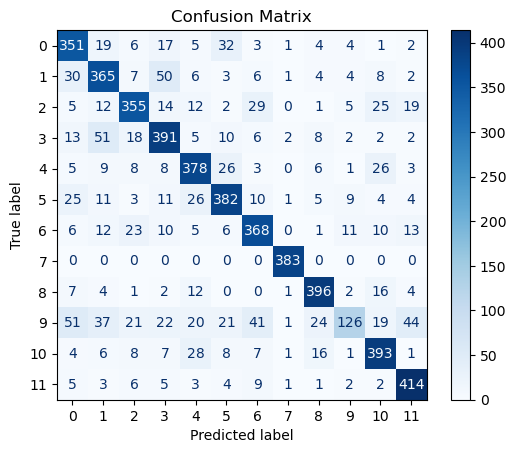

In [16]:
#confusion matrix

import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, confusion_matrix, ConfusionMatrixDisplay


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()


